Index(['TEAM_ID', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away',
       'TEAM_ID_OPP', 'MATCHUP_ID', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN',
       'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF',
       'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF',
       'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded'],
      dtype='object')


C:\Users\ghadf\AppData\Local\Temp\ipykernel_19260\1601466625.py:45: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = preprocessor_data.corr()


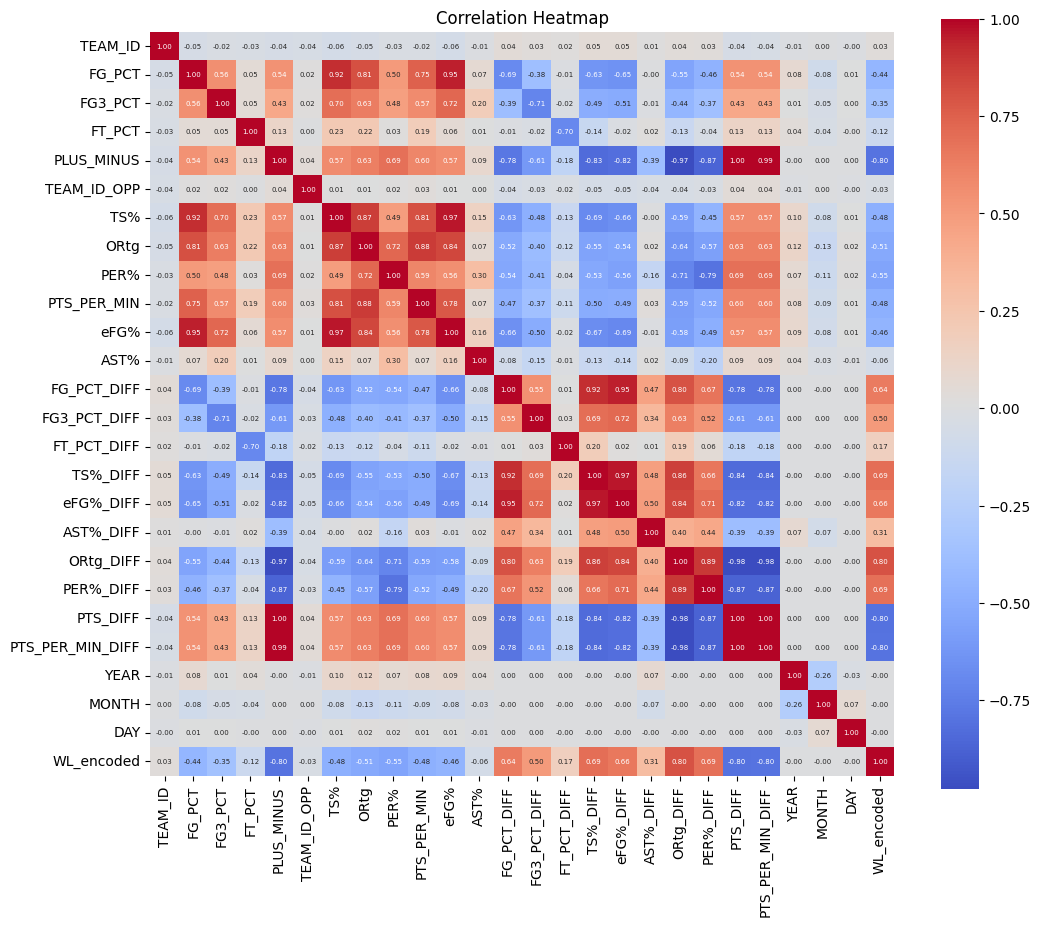

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load



# Load the data
data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_threeptera_prepreprocess_data.csv')


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
preprocessor_data = data[[col for col in data.columns if col != 'WL'] + ['WL']]

#drop the columns that are not needed
x_excluded_independent_variables = [ 'TEAM_ABBREVIATION', 'WL', 'FGA', 'TOV', 'TEAM_NAME', 'GAME_ID', 'PPM', 'RPM', 'APM', 'SPM', 'BPM', 'TPM',
                                    'PER', 'OPM', 'DPM', 'USG%', 'FG3A', 'OREB', 'PF', 'MIN', 'PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 
                                    'AST', 'PF', 'STL', 'BLK', 'DREB', 'Offensive_Possessions', 'SEASON_ID', 'MATCHUP', 'GAME_DATE', #, 
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP', 'SEASON_ID_OPP', 'Home_Away_OPP' #,  'Defensive_Possessions'
                                    , 'TEAM_NAME_OPP', 'WL_OPP', 'MIN_OPP', 'PF_OPP', 'DREB_OPP','PTS_PER_MIN_OPP'] #, 'TEAM_ID_OPP'

#drop the columns that are not needed
preprocessor_data = preprocessor_data.drop(x_excluded_independent_variables, axis=1)
print(preprocessor_data.columns)

# Create a correlation matrix for the selected columns
correlation_matrix = preprocessor_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'
columns_to_drop = [y_column]


# Define feature lists
categorical_features = ['TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
numerical_features = [col for col in preprocessor_data.columns if col not in categorical_features + columns_to_drop]

# Transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

one_hot_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('one_hot', one_hot_transformer, categorical_features)
])

# Apply the preprocessor to the data
X = preprocessor_data.drop(columns=columns_to_drop, axis=1)
y = preprocessor_data[y_column]

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Fit the preprocessor to the data
preprocessor.fit(X)

# Transform the data using the already fitted preprocessor
X_preprocessed = preprocessor.transform(X)

print('Before preprocessing = ', X.shape)
print('After preprocessing = ', X_preprocessed.shape)
print('y shape = ', y_encoded.shape)

# Checking if there are any null values after preprocessing
print(pd.DataFrame(X_preprocessed).isnull().sum())


Before preprocessing =  (13704, 27)
After preprocessing =  (13704, 520)
y shape =  (13704,)
0    0
dtype: int64


In [3]:
# Determine sequence length automatically based on data
def determine_sequence_length(data, max_length=None):
    # For example, let's say you decide that at least 10% of your data should be used as a sequence
    sequence_length = int(len(data) * 0.01)
    
    # If you've set a maximum length, use the minimum of the two
    if max_length:
        sequence_length = min(sequence_length, max_length)
    
    return sequence_length

seq_length = determine_sequence_length(X)
print('Sequence length:', seq_length)

Sequence length: 137


In [4]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
HIDDEN_SIZE = 128
TEST_SIZE = 0.2
RANDOM_STATE = 42
seq_length = determine_sequence_length(X)


In [5]:
# Split data and create tensors
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=TEST_SIZE, shuffle=False)
# convert X_train and X_test back to dense numpy arrays
X_train = X_train.toarray()
X_test = X_test.toarray()
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.float32))

# DataLoader setup
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
# LSTM Model Definition
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Reshaping the input tensor to (batch_size, seq_length, input_size)
        x = x.unsqueeze(1)
        
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        output, _ = self.lstm(x, (h_0, c_0))
        hn = output[:, -1, :]
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out.squeeze()

In [7]:
# Model, Loss, Optimizer Setup
input_size = X_train_tensor.shape[1]
model = LSTM1(1, input_size, HIDDEN_SIZE, 1).float()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()


Epoch 10/100, Loss: 0.0002
Epoch 20/100, Loss: 0.0000
Epoch 30/100, Loss: 0.0000
Epoch 40/100, Loss: 0.0000
Epoch 50/100, Loss: 0.0000
Epoch 60/100, Loss: 0.0000
Epoch 70/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000


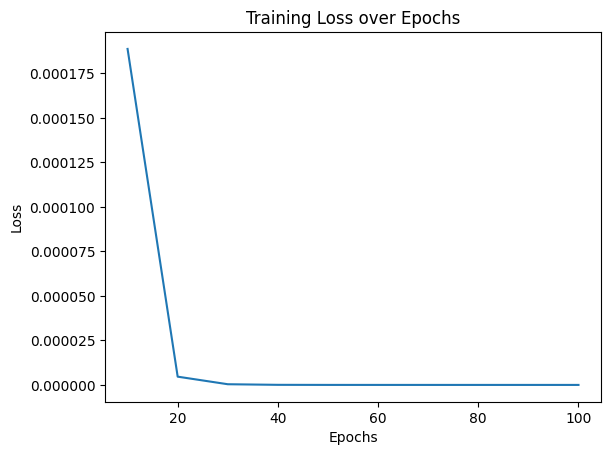

In [8]:
losses = []  # Initialize an empty list to store losses

# Training
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0  # Reset epoch loss
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features.float())  # Ensure float type
        loss = criterion(outputs, labels.float())  # Directly use labels without unsqueezing
        epoch_loss += loss.item()  # Accumulate loss
        loss.backward()
        optimizer.step()

    # Only save and print every 10 epochs
    if (epoch + 1) % 10 == 0:
        average_epoch_loss = epoch_loss / len(train_loader)
        losses.append(average_epoch_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {average_epoch_loss:.4f}")

# Plotting the loss over epochs
plt.plot(range(10, NUM_EPOCHS+1, 10), losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [9]:
# Evaluation
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features.float())
        predicted = (torch.sigmoid(outputs).data > 0.5).float()
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

print('Accuracy: {:.2f}%'.format(100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)))

# Confusion Matrix & Classification Report
confusion = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(confusion)

report = classification_report(all_labels, all_predictions)
print("\nClassification Report:")
print(report)

Accuracy: 99.56%
Confusion Matrix:
[[1313    2]
 [  10 1416]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1315
         1.0       1.00      0.99      1.00      1426

    accuracy                           1.00      2741
   macro avg       1.00      1.00      1.00      2741
weighted avg       1.00      1.00      1.00      2741



In [10]:
#Save Model and preprocessor

# Save Model and Preprocessor Paths
pipeline_save_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\lstm_nn_preprocessor.joblib'
model_save_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\lstm_nn_model.pth'


# Save the preprocessor
dump(preprocessor, pipeline_save_path)

# Save the LSTM model
torch.save(model.state_dict(), model_save_path)


In [11]:
# Load the Preprocessor and Model
loaded_pipeline = load(pipeline_save_path)

model = LSTM1(1, input_size, HIDDEN_SIZE, 1).float()
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

LSTM1(
  (lstm): LSTM(520, 128, batch_first=True)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [12]:
#read "unseen" data so we can test what these models would predict for the 2022 playoffs
#prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_test_unseen_dataset.csv')
prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv')

#print(prediction_data.head())

# Drop the columns that are not needed Matchup
#prediction_data = prediction_data.drop(columns=['MATCHUP'])
    
# Define the desired feature order
#feature_order = ['TEAM_ID', 'MATCHUP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'FG_PCT_OPP', 'FG3_PCT_OPP', 
                  #'FT_PCT_OPP', 'PLUS_MINUS_OPP', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 
                 #'DRtg', 'DPER%', 'YEAR', 'MONTH', 'DAY',
                 #'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF'] #, 'MATCHUP'

feature_names = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 
                     'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 
                     'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']

feature_order = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','TEAM_ID', 'TEAM_ID_OPP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'MATCHUP_ID',# 'FG_PCT_OPP', 'FG3_PCT_OPP',  'SEASON_ID', 'GAME_ID'
                   'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', #'FT_PCT_OPP', 'PLUS_MINUS_OPP','TS%_OPP', 'eFG%_OPP', 'AST%_OPP', , 'MATCHUP'
                  'YEAR', 'MONTH', 'DAY', #'DRtg', 'DPER%',
                 'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF'] #, 'MATCHUP'

#does feature_names = feature_order?
print(len(feature_names))
print(len(feature_order))

# Reorder columns in the new_data DataFrame
prediction_data = prediction_data[feature_order]
print(prediction_data.head())

27
27
   PTS_PER_MIN  PTS_DIFF  PTS_PER_MIN_DIFF     TEAM_ID  TEAM_ID_OPP    FG_PCT  \
0     0.460023      -235         -0.002370  1610612756   1610612747  0.466249   
1     0.462266       451          0.007977  1610612747   1610612756  0.469766   
2     0.459191       113          0.002039  1610612755   1610612749  0.464571   
3     0.486492      1816          0.030805  1610612749   1610612755  0.473682   

    FG3_PCT    FT_PCT  PLUS_MINUS Home_Away MATCHUP_ID       TS%        ORtg  \
0  0.349655  0.811272   -0.733333      Away     LALPHX  0.565746  109.320620   
1  0.341616  0.737743    1.845528      Home     LALPHX  0.565838  108.248419   
2  0.360043  0.783743    0.457500      Away     MILPHI  0.570568  110.011593   
3  0.363579  0.747414    7.348988      Home     MILPHI  0.582406  112.599600   

         PER%      eFG%       AST%  YEAR  MONTH  DAY  FG_PCT_DIFF  \
0  118.127497  0.527802  28.923854  2023     10   26    -0.001937   
1  117.738334  0.531888  28.389080  2023     10  

In [13]:
# Ensure prediction_data has the right columns
assert set(feature_order).issubset(prediction_data.columns), "Some features are missing in the unseen data."


In [14]:
# Preprocess the unseen data
X_new_preprocessed = loaded_pipeline.transform(prediction_data)
print('After preprocessing:', X_new_preprocessed.shape)


After preprocessing: (4, 520)


In [15]:
# Make predictions using the loaded model
X_new_preprocessed = X_new_preprocessed.toarray()
X_new_tensor = torch.tensor(X_new_preprocessed.astype(np.float32))
logits = model(X_new_tensor)

# Convert logits to probabilities and then to binary labels
probabilities = torch.sigmoid(logits)
#print(probabilities)
predicted_labels = (probabilities > 0.5).float()

# Add predictions to the original dataframe
prediction_data['PREDICTION'] = predicted_labels.detach().numpy()
print(prediction_data.head())
print(prediction_data.shape)

   PTS_PER_MIN  PTS_DIFF  PTS_PER_MIN_DIFF     TEAM_ID  TEAM_ID_OPP    FG_PCT  \
0     0.460023      -235         -0.002370  1610612756   1610612747  0.466249   
1     0.462266       451          0.007977  1610612747   1610612756  0.469766   
2     0.459191       113          0.002039  1610612755   1610612749  0.464571   
3     0.486492      1816          0.030805  1610612749   1610612755  0.473682   

    FG3_PCT    FT_PCT  PLUS_MINUS Home_Away MATCHUP_ID       TS%        ORtg  \
0  0.349655  0.811272   -0.733333      Away     LALPHX  0.565746  109.320620   
1  0.341616  0.737743    1.845528      Home     LALPHX  0.565838  108.248419   
2  0.360043  0.783743    0.457500      Away     MILPHI  0.570568  110.011593   
3  0.363579  0.747414    7.348988      Home     MILPHI  0.582406  112.599600   

         PER%      eFG%       AST%  YEAR  MONTH  DAY  FG_PCT_DIFF  \
0  118.127497  0.527802  28.923854  2023     10   26    -0.001937   
1  117.738334  0.531888  28.389080  2023     10   26   

In [16]:

# Convert YEAR, MONTH, DAY into a date column
prediction_data['Date'] = pd.to_datetime(prediction_data[['YEAR', 'MONTH', 'DAY']])
prediction_data = prediction_data.sort_values(by=['Date'])

# Merge with unique teams data
df1 = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv')
unique_teams = df1[['TEAM_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION']].drop_duplicates()
prediction_data = prediction_data.merge(unique_teams, on='TEAM_ID', how='left')

# Drop unnecessary columns
columns_to_drop = ["TEAM_ID", "TEAM_ID_OPP", "YEAR", "MONTH", "DAY"]
prediction_data = prediction_data.drop(columns=columns_to_drop)

# filter for todays games
today = pd.Timestamp.today().normalize()
prediction_data = prediction_data[prediction_data['Date'] == today]

# Display summarized results
season_pred = prediction_data  # Assuming you want all columns. Adjust accordingly.
print(season_pred.head())

# Save the predictions
#season_pred.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\ltsm_season_pred.csv', index=False)
print(season_pred.shape)

   PTS_PER_MIN  PTS_DIFF  PTS_PER_MIN_DIFF    FG_PCT   FG3_PCT    FT_PCT  \
0     0.460023      -235         -0.002370  0.466249  0.349655  0.811272   
1     0.462266       451          0.007977  0.469766  0.341616  0.737743   
2     0.459191       113          0.002039  0.464571  0.360043  0.783743   
3     0.486492      1816          0.030805  0.473682  0.363579  0.747414   

   PLUS_MINUS Home_Away MATCHUP_ID       TS%        ORtg        PER%  \
0   -0.733333      Away     LALPHX  0.565746  109.320620  118.127497   
1    1.845528      Home     LALPHX  0.565838  108.248419  117.738334   
2    0.457500      Away     MILPHI  0.570568  110.011593  117.893095   
3    7.348988      Home     MILPHI  0.582406  112.599600  124.944067   

       eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  \
0  0.527802  28.923854    -0.001937      0.005679    -0.042106  0.004521   
1  0.531888  28.389080    -0.019586      0.001584     0.032873 -0.014015   
2  0.530044  27.329435    -0.0

In [17]:

# Display results by each team
for team_name in season_pred['TEAM_NAME'].unique():
    team_results = season_pred[season_pred['TEAM_NAME'] == team_name]
    print(f"Results for {team_name} (TEAM_NAME {team_name}):")
    print(team_results.groupby(['TEAM_NAME', 'PREDICTION']).size().reset_index(name='COUNT'))
    print("-------------------------------")

Results for Phoenix Suns (TEAM_NAME Phoenix Suns):
      TEAM_NAME  PREDICTION  COUNT
0  Phoenix Suns         1.0      1
-------------------------------
Results for Los Angeles Lakers (TEAM_NAME Los Angeles Lakers):
            TEAM_NAME  PREDICTION  COUNT
0  Los Angeles Lakers         0.0      1
-------------------------------
Results for Philadelphia 76ers (TEAM_NAME Philadelphia 76ers):
            TEAM_NAME  PREDICTION  COUNT
0  Philadelphia 76ers         1.0      1
-------------------------------
Results for Milwaukee Bucks (TEAM_NAME Milwaukee Bucks):
         TEAM_NAME  PREDICTION  COUNT
0  Milwaukee Bucks         0.0      1
-------------------------------


In [18]:
from datetime import datetime

from datetime import datetime
import pandas as pd
import os

# 1. Create a DataFrame for today's outcomes based on prediction_data
today_predictions = prediction_data.copy()

# 2. Add today's date and recording timestamp
today_predictions['date_prediction_recorded'] = pd.Timestamp.today()

#filter for ATLCHA matchup_id
#today_predictions = today_predictions[today_predictions['MATCHUP_ID'] == 'ATLCHA']

# Define the path to the saved predictions
saved_predictions_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\ltsm_season_pred.csv'

# 3. Check if the saved predictions file exists
if not os.path.exists(saved_predictions_path):
    # If it doesn't exist, create it from today's predictions
    today_predictions.to_csv(saved_predictions_path, index=False)
    print(today_predictions.shape)
else:
    # If it exists, load it and update
    saved_predictions = pd.read_csv(saved_predictions_path)
    # Normalize the 'Date' column to remove time portion
    saved_predictions['Date'] = pd.to_datetime(saved_predictions['Date']).dt.normalize()

    print(saved_predictions.shape)

    print(today_predictions.shape)
    # 4. Concatenate existing and new predictions
    all_predictions = pd.concat([saved_predictions, today_predictions], ignore_index=True)
    
    # 5. Sort by date recorded, matchup id, and home_away
    all_predictions.sort_values(by=['date_prediction_recorded', 'MATCHUP_ID', 'Home_Away'], ascending=[True, True, True], inplace=True)
    
    # 6. Remove duplicates, keeping only the newest entry and not deleting previous days predictions
    all_predictions.drop_duplicates(subset=['MATCHUP_ID', 'TEAM_NAME', 'Date'], keep='first', inplace=True)
    
    # Sort by date and reset index
    all_predictions = all_predictions.sort_values(by=['Date']).reset_index(drop=True)
    
    # 7. Save the updated DataFrame back to CSV
    all_predictions.to_csv(saved_predictions_path, index=False)

# 8. Display the results
print(all_predictions.head())
print(all_predictions.shape)

(24, 27)
(4, 27)
   PTS_PER_MIN  PTS_DIFF  PTS_PER_MIN_DIFF    FG_PCT   FG3_PCT    FT_PCT  \
0     0.465605       -74         -0.001553  0.471964  0.370370  0.771503   
1     0.464352      1099          0.019943  0.454258  0.351115  0.785620   
2     0.472075      -466         -0.010859  0.461538  0.355345  0.768225   
3     0.466357       894          0.016651  0.461420  0.343711  0.754930   
4     0.466284      -352         -0.006508  0.464642  0.348352  0.755110   

   PLUS_MINUS Home_Away MATCHUP_ID       TS%        ORtg        PER%  \
0   -0.267925      Home     DALSAS  0.565923  109.847075  120.336476   
1    4.694372      Home     MINTOR  0.561062  110.571862  121.855670   
2   -2.504186      Away     MINTOR  0.566614  109.120416  116.845716   
3    4.099099      Home     MEMNOP  0.555688  109.755342  125.015490   
4   -1.735484      Away     MEMNOP  0.561744  108.681655  117.798823   

       eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  \
0  0.532682  29.0

In [20]:
#print just predictions and matchup_id
#print(all_predictions[['MATCHUP_ID', 'TEAM_NAME', 'PREDICTION']])

#filter all_predictions for just today
today = pd.Timestamp.today().normalize()
all_predictions = all_predictions[all_predictions['Date'] == today]

# sum prediction column by matchup_id
print(all_predictions.groupby(['MATCHUP_ID', 'PREDICTION']).size().reset_index(name='COUNT'))




  MATCHUP_ID  PREDICTION  COUNT
0     LALPHX         0.0      1
1     LALPHX         1.0      1
2     MILPHI         0.0      1
3     MILPHI         1.0      1
